In [172]:
import math
import textwrap
import warnings

import matplotlib.pyplot as plt
import numpy as np
# Importing necessary modules
import pandas as pd
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
from scipy.stats import wilcoxon

warnings.filterwarnings("ignore")


In [173]:
# Rename all the unnamed columns for consistency and easy data handeling
first_columns = ["Participant_ID", "RSVP", "TTS", "Trial_No"]

with open('Data/LanePositionDifference.csv') as f:
    lpd_num_cols = max(len(line.split(',')) for line in f)
with open('Data/BrakingInput.csv') as f:
    bi_num_cols = max(len(line.split(',')) for line in f)
with open('Data/SteeringWheelAngles.csv') as f:
    swa_num_cols = max(len(line.split(',')) for line in f)
with open('Data/SteeringWheelVelocity.csv') as f:
    swv_num_cols = max(len(line.split(',')) for line in f)

# Extracting the driving performance metric data
rt_df = pd.read_csv("Data/ReactionTimes.csv")
lpd_df = pd.read_csv("Data/LanePositionDifference.csv",
                     names=(first_columns + ["DP" + str(i) for i in range(0, lpd_num_cols - 4)]), skiprows=1)
bi_df = pd.read_csv("Data/BrakingInput.csv", names=(first_columns + ["DP" + str(i) for i in range(0, bi_num_cols - 4)]),
                    skiprows=1)
swa_df = pd.read_csv("Data/SteeringWheelAngles.csv",
                     names=(first_columns + ["DP" + str(i) for i in range(0, swa_num_cols - 4)]), skiprows=1)
swv_df = pd.read_csv("Data/SteeringWheelVelocity.csv",
                     names=(first_columns + ["DP" + str(i) for i in range(0, swv_num_cols - 4)]), skiprows=1)
scenario_df = pd.read_csv("Data/Scenario.csv")
collisions_df = pd.read_csv("Data/CollisionData.csv")

# Extracting reading comprehension data. NOTE: Extract numeric data from UBC Qualtrics
comp_test_df = pd.read_csv("Data/ComprehensionTest.csv")

# Extracting the survey data
nasa_tlx = pd.read_csv("Data/NASA-TLX.csv")
pre_study = pd.read_csv("Data/Pre-Study.csv")
post_study = pd.read_csv("Data/Post-Study.csv")

# Giving column names to all the tables that don't have a name.
rt_columns = first_columns + ["DP" + str(i) for i in range(0, rt_df.shape[1] - 4)]
rt_df.columns = rt_columns
scenario_columns = first_columns + ["DP" + str(i) for i in range(0, scenario_df.shape[1] - 4)]
scenario_df.columns = scenario_columns
collisions_df.columns = first_columns + ["Event"]

In [174]:
# Utility Methods here
def is_outlier(data_point, q1, q3):
    IQR = q3 - q1
    return data_point < q1 - 1.5 * IQR or data_point > q3 + 1.5 * IQR


def get_stats(np_array):
    q1, q3 = np.percentile(np.sort(np_array), [25, 75])
    return (q1, q3)


def remove_outliers(df, column_name):
    q1_rsvp, q3_rsvp = get_stats(np.array(df[df["TPTAA"] == "RSVPNAA"][column_name].values))
    q1_rsvpa, q3_rsvpa = get_stats(np.array(df[df["TPTAA"] == "RSVPAA"][column_name].values))
    q1_stp, q3_stp = get_stats(np.array(df[df["TPTAA"] == "STPNAA"][column_name].values))
    q1_stpa, q3_stpa = get_stats(np.array(df[df["TPTAA"] == "STPAA"][column_name].values))
    index_list = []
    for i in range(0, df.shape[0]):
        if df.iloc[i]["TPTAA"] == "RSVPNAA":
            if is_outlier(df.iloc[i][column_name], q1_rsvp, q3_rsvp):
                index_list.append(i)
        elif df.iloc[i]["TPTAA"] == "RSVPAA":
            if is_outlier(df.iloc[i][column_name], q1_rsvpa, q3_rsvpa):
                index_list.append(i)
        elif df.iloc[i]["TPTAA"] == "STPNAA":
            if is_outlier(df.iloc[i][column_name], q1_stp, q3_stp):
                index_list.append(i)
        elif is_outlier(df.iloc[i][column_name], q1_stpa, q3_stpa):
            index_list.append(i)
    df.drop(index_list, axis=0, inplace=True)
    df.reset_index(inplace=True, drop=True)


def generate_refined(old_df, old_data_col, new_data_col):
    refined_df = pd.DataFrame(columns=["Participant_ID", "TPT", "Audio Assistance", new_data_col])
    refined_df[new_data_col] = refined_df[new_data_col].astype(float)

    for participant in old_df["Participant_ID"].unique():
        p_data = old_df[(old_df["Participant_ID"] == participant)]
        # Inserting data of the first trial
        try:
            new_arr_1 = [participant, "RSVP", "NAA",
                         p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 0)][old_data_col].values[0]]
            refined_df.loc[len(refined_df)] = new_arr_1
        except:
            print("WARNING: Data point missing")
        try:
            new_arr_2 = [participant, "RSVP", "AA",
                         p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 1)][old_data_col].values[0]]
            refined_df.loc[len(refined_df)] = new_arr_2
        except:
            print("WARNING: Data point missing")
        try:
            new_arr_3 = [participant, "STP", "NAA",
                         p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)][old_data_col].values[0]]
            refined_df.loc[len(refined_df)] = new_arr_3
        except:
            print("WARNING: Data point missing")
        try:
            new_arr_4 = [participant, "STP", "AA",
                         p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 1)][old_data_col].values[0]]
            refined_df.loc[len(refined_df)] = new_arr_4
        except:
            print("WARNING: Data point missing")

        # Inserting data of the second trial
        try:
            new_arr_1 = [participant, "RSVP", "NAA",
                         p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 0)][old_data_col].values[1]]
            refined_df.loc[len(refined_df)] = new_arr_1
        except:
            print("WARNING: Data point missing")
        try:
            new_arr_2 = [participant, "RSVP", "AA",
                         p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 1)][old_data_col].values[1]]
            refined_df.loc[len(refined_df)] = new_arr_2
        except:
            print("WARNING: Data point missing")
        try:
            new_arr_3 = [participant, "STP", "NAA",
                         p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)][old_data_col].values[1]]
            refined_df.loc[len(refined_df)] = new_arr_3
        except:
            print("WARNING: Data point missing")
        try:
            new_arr_4 = [participant, "STP", "AA",
                         p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 1)][old_data_col].values[1]]
            refined_df.loc[len(refined_df)] = new_arr_4
        except:
            print("WARNING: Data point missing")
    return refined_df


def under_sampling(df, data_col):
    rus = RandomUnderSampler(random_state=50)
    df_c2, df_c1 = rus.fit_resample(df[data_col].values.reshape((-1, 1)), df["TPTAA"].astype(str))
    new_df = pd.DataFrame()
    new_df["TPTAA"] = df_c1
    new_df[data_col] = df_c2.astype(float)
    return new_df


def create_seperate_arrays(df, data_col):
    rt_stp = df[df["TPTAA"] == "STPNAA"][data_col].values
    rt_stpa = df[df["TPTAA"] == "STPAA"][data_col].values
    rt_rsvp = df[df["TPTAA"] == "RSVPNAA"][data_col].values
    rt_rsvpa = df[df["TPTAA"] == "RSVPAA"][data_col].values
    return (rt_stp, rt_stpa, rt_rsvp, rt_rsvpa)


def plot_driving_metric(df, data_col, is_percentage):
    df_decoupled = decouple_df(df)
    plot = sns.barplot(data=df_decoupled, x="Text Presentation Technique", y=data_col, hue="Audio Assistance",
                       capsize=0.1)
    if is_percentage:
        for p in plot.containers:
            plot.bar_label(p, fmt='%.3f%%', label_type='center')
    else:
        for p in plot.containers:
            plot.bar_label(p, fmt='%.3f', label_type='center')


def plot_nasa_tlx(df, y_label, is_percentage=True):
    df_decoupled = decouple_df(df, col_name=y_label)
    plot = sns.barplot(data=df_decoupled, x="Text Presentation Technique", y=y_label, hue="Audio Assistance",
                       capsize=0.1)
    if is_percentage:
        for p in plot.containers:
            plot.bar_label(p, fmt='%.3f%%', label_type='center')
    else:
        for p in plot.containers:
            plot.bar_label(p, fmt='%.3f', label_type='center')
    plt.figure()


def analyze_nasa_tlx(df, data_col, plot_y_label, is_percentage=True):
    # Plotting the data points
    plot_nasa_tlx(df, y_label=plot_y_label, is_percentage=is_percentage)
    r_stp, r_stpa, r_rsvp, r_rsvpa = create_seperate_arrays(df, data_col=data_col)
    # Running Shapiro test
    if not (stats.shapiro(r_stp)[1] < 0.05 or stats.shapiro(r_stp)[1] < 0.05 or stats.shapiro(r_stp)[1] < 0.05 or
            stats.shapiro(r_stp)[1] < 0.05):
        # Run paired wilcoxon test
        stat1, p1 = wilcoxon(r_rsvp, r_stp, alternative='less')
        print("Test: R_rsvp < R_stp [p value: {}]".format(p1))
        stat2, p2 = wilcoxon(r_rsvpa, r_stpa, alternative='less')
        print("Test: R_rsvpa < R_stpa [p value: {}]".format(p2))
        stat3, p3 = wilcoxon(r_rsvpa, r_rsvp, alternative='less')
        print("Test: R_rsvpa < R_rsvp [p value: {}]".format(p3))
        stat4, p4 = wilcoxon(r_stpa, r_stp, alternative='less')
        print("Test: R_stpa < R_stp [p value: {}]".format(p4))
        stat5, p5 = wilcoxon(r_rsvp, r_stp, alternative='greater')
        print("Test: R_rsvp > R_stp [p value: {}]".format(p5))
        stat6, p6 = wilcoxon(r_rsvpa, r_stpa, alternative='greater')
        print("Test: R_rsvpa > R_stpa [p value: {}]".format(p6))
        stat7, p7 = wilcoxon(r_rsvpa, r_rsvp, alternative='greater')
        print("Test: R_rsvpa > R_rsvp [p value: {}]".format(p7))
        stat8, p8 = wilcoxon(r_stpa, r_stp, alternative='greater')
        print("Test: R_stpa > R_stp [p value: {}]".format(p8))
    else:
        # Run the p-test if the
        # Test if H_a: RT_rsvp  data set is normal< RT_stp
        print("H_0: R_rsvp = R_stp ; H_a: R_rsvp < R_stp")
        print(stats.ttest_rel(a=r_rsvp, b=r_stp, alternative="less"))
        print("H_0: R_rsvpa = R_stpa ; H_a: R_rsvpa < R_stpa")
        print(stats.ttest_rel(a=r_rsvpa, b=r_stpa, alternative="less"))
        # Test if H_a: R_aae < R_aad
        print("H_0: R_rsvpa = R_rsvp ; H_a: R_rsvpa < R_rsvp")
        print(stats.ttest_rel(a=r_rsvpa, b=r_rsvp, alternative="less"))
        print("H_0: R_stpa = R_stp ; H_a: R_stpa < R_stp")
        print(stats.ttest_rel(a=r_stpa, b=r_stp, alternative="less"))

        # Test if H_a: R_rsvp > R_stp
        print("H_0: R_rsvp = R_stp ; H_a: R_rsvp > R_stp")
        print(stats.ttest_rel(a=r_rsvp, b=r_stp, alternative="greater"))
        print("H_0: R_rsvpa = R_stpa ; H_a: R_rsvpa > R_stpa")
        print(stats.ttest_rel(a=r_rsvpa, b=r_stpa, alternative="greater"))
        # Test if H_a: R_aae > R_aad
        print("H_0: R_rsvpa = R_rsvp ; H_a: R_rsvpa > R_rsvp")
        print(stats.ttest_rel(a=r_rsvpa, b=r_rsvp, alternative="greater"))
        print("H_0: R_stpa = R_stp ; H_a: R_stpa > R_stp")
        print(stats.ttest_rel(a=r_stpa, b=r_stp, alternative="greater"))


def decouple_df(df, col_name=None):
    # This method also renames the values of "Audio Assistance" Column
    col_name = list(df.columns)[1] if col_name is None else col_name
    new_df = pd.DataFrame(columns=["Text Presentation Technique", "Audio Assistance", col_name])
    for index, row in df.iterrows():
        new_row = []
        if "RSVP" in row["TPTAA"]:
            new_row.append("RSVP")
        else:
            new_row.append("STP")

        if "NAA" in row["TPTAA"]:
            new_row.append("Audio Assistance Disabled")
        else:
            new_row.append("Audio Assistance Enabled")
        new_row.append(row[df.columns[1]])
        new_df = new_df.append(
            {'Text Presentation Technique': new_row[0], 'Audio Assistance': new_row[1], col_name: new_row[2]},
            ignore_index=True)
    new_df[col_name] = new_df[col_name].astype(float)
    new_df.sort_values(['Text Presentation Technique', 'Audio Assistance'], ascending=[False, True], inplace=True)
    return new_df


def test_hypothesis(arr_stp, arr_stpa, arr_rsvp, arr_rsvpa, metric_name = "UNKNOWN"):
    # Running Shapiro test to check if the dataset is normal
    is_normal = True
    if stats.shapiro(arr_stp)[1] < 0.05 or stats.shapiro(arr_stpa)[1] < 0.05 or stats.shapiro(arr_rsvp)[1] < 0.05 or \
            stats.shapiro(arr_rsvpa)[1] < 0.05:
        is_normal = False
        print("Data is not Normal. Running Wilcoxon Signed Rank Test.")
    else:
        print("Data is Normal. Running Paired T-test.")

    if is_normal:
        # Run Paired T-test since the
        stat1, p1 = stats.ttest_rel(arr_rsvp, arr_stp, alternative='less')
        print("Test: {}_rsvp < {}_stp {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p1 < 0.05 else "[INSIGNIFICANT]", p1))

        stat2, p2 = stats.ttest_rel(arr_rsvpa, arr_stpa, alternative='less')
        print("Test: {}_rsvpa < {}_stpa {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p2 < 0.05 else "[INSIGNIFICANT]", p2))

        stat3, p3 = stats.ttest_rel(arr_rsvpa, arr_rsvp, alternative='less')
        print("Test: {}_rsvpa < {}_rsvp {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p3 < 0.05 else "[INSIGNIFICANT]", p3))

        stat4, p4 = stats.ttest_rel(arr_stpa, arr_stp, alternative='less')
        print("Test: {}_stpa < {}_stp {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p4 < 0.05 else "[INSIGNIFICANT]", p4))

        stat5, p5 = stats.ttest_rel(arr_rsvp, arr_stp, alternative='greater')
        print("Test: {}_rsvp > {}_stp {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p5 < 0.05 else "[INSIGNIFICANT]", p5))

        stat6, p6 = stats.ttest_rel(arr_rsvpa, arr_stpa, alternative='greater')
        print("Test: {}_rsvpa > {}_stpa {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p6 < 0.05 else "[INSIGNIFICANT]", p6))

        stat7, p7 = stats.ttest_rel(arr_rsvpa, arr_rsvp, alternative='greater')
        print("Test: {}_rsvpa > {}_rsvp {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p7 < 0.05 else "[INSIGNIFICANT]", p7))

        stat8, p8 = stats.ttest_rel(arr_stpa, arr_stp, alternative='greater')
        print("Test: {}_stpa > {}_stp {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p8 < 0.05 else "[INSIGNIFICANT]", p8))
    else:
        # Run Wilcoxon Signed Rank Test
        stat1, p1 = wilcoxon(arr_rsvp, arr_stp, alternative='less')
        print("Test: {}_rsvp < {}_stp {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p1 < 0.05 else "[INSIGNIFICANT]", p1))

        stat2, p2 = wilcoxon(arr_rsvpa, arr_stpa, alternative='less')
        print("Test: {}_rsvpa < {}_stpa {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p2 < 0.05 else "[INSIGNIFICANT]", p2))

        stat3, p3 = wilcoxon(arr_rsvpa, arr_rsvp, alternative='less')
        print("Test: {}_rsvpa < {}_rsvp {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p3 < 0.05 else "[INSIGNIFICANT]", p3))

        stat4, p4 = wilcoxon(arr_stpa, arr_stp, alternative='less')
        print("Test: {}_stpa < {}_stp {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p4 < 0.05 else "[INSIGNIFICANT]", p4))

        stat5, p5 = wilcoxon(arr_rsvp, arr_stp, alternative='greater')
        print("Test: {}_rsvp > {}_stp {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p5 < 0.05 else "[INSIGNIFICANT]", p5))

        stat6, p6 = wilcoxon(arr_rsvpa, arr_stpa, alternative='greater')
        print("Test: {}_rsvpa > {}_stpa {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p6 < 0.05 else "[INSIGNIFICANT]", p6))

        stat7, p7 = wilcoxon(arr_rsvpa, arr_rsvp, alternative='greater')
        print("Test: {}_rsvpa > {}_rsvp {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p7 < 0.05 else "[INSIGNIFICANT]", p7))

        stat8, p8 = wilcoxon(arr_stpa, arr_stp, alternative='greater')
        print("Test: {}_stpa > {}_stp {} [p value: {}]".format(metric_name, metric_name, "[***SIGNIFICANT***]" if p8 < 0.05 else "[INSIGNIFICANT]", p8))

In [175]:
exclusion = ['P01', 'P02', 'P03', 'P04', 'P05', 'P09']

# Excluding certain participants' driving performance
# Excluding certain participants' reading comprehension performance
# Exclusing certain participants' subjective surveys
for participant in exclusion:
    rt_df = rt_df[rt_df["Participant_ID"] != participant]
    lpd_df = lpd_df[lpd_df["Participant_ID"] != participant]
    bi_df = bi_df[bi_df["Participant_ID"] != participant]
    swa_df = swa_df[swa_df["Participant_ID"] != participant]
    swv_df = swv_df[swv_df["Participant_ID"] != participant]
    comp_test_df = comp_test_df[comp_test_df["Q1"] != participant]
    nasa_tlx = nasa_tlx[nasa_tlx["Q1"] != participant]
    pre_study = pre_study[pre_study["ID"] != participant]
    post_study = post_study[post_study["Q1"] != participant]

# TODO: Write code to remove the data point of Major collisions.
# WARNING: Take note of the leading white space in the data types of Event Column
exclusion_df = collisions_df[collisions_df["Event"] == " Major Collision"]
for index, row in exclusion_df.iterrows():
    rt_df = rt_df[(rt_df["Participant_ID"] != row["Participant_ID"]) | (rt_df["RSVP"] != row["RSVP"]) | (
            rt_df["TTS"] != row["TTS"]) | (rt_df["Trial_No"] != row["Trial_No"])]
    lpd_df = lpd_df[(lpd_df["Participant_ID"] != row["Participant_ID"]) | (lpd_df["RSVP"] != row["RSVP"]) | (
            lpd_df["TTS"] != row["TTS"]) | (lpd_df["Trial_No"] != row["Trial_No"])]
    bi_df = bi_df[(bi_df["Participant_ID"] != row["Participant_ID"]) | (bi_df["RSVP"] != row["RSVP"]) | (
            bi_df["TTS"] != row["TTS"]) | (bi_df["Trial_No"] != row["Trial_No"])]
    swa_df = swa_df[(swa_df["Participant_ID"] != row["Participant_ID"]) | (swa_df["RSVP"] != row["RSVP"]) | (
            swa_df["TTS"] != row["TTS"]) | (swa_df["Trial_No"] != row["Trial_No"])]
    swv_df = swv_df[(swv_df["Participant_ID"] != row["Participant_ID"]) | (swv_df["RSVP"] != row["RSVP"]) | (
            swv_df["TTS"] != row["TTS"]) | (swv_df["Trial_No"] != row["Trial_No"])]
# TODO: Reset the indexes of the dataframes once the outliers are removed.

In [176]:
# Analyze how many collisions occurred for each case.
c_stp = len(collisions_df[
                ((collisions_df["Event"] == " Minor Collision") | (collisions_df["Event"] == " Major Collision")) & (
                            (collisions_df["RSVP"] == 0) & (collisions_df["TTS"] == 0))].values)
c_stpa = len(collisions_df[
                 ((collisions_df["Event"] == " Minor Collision") | (collisions_df["Event"] == " Major Collision")) & (
                             (collisions_df["RSVP"] == 0) & (collisions_df["TTS"] == 1))].values)
c_rsvp = len(collisions_df[
                 ((collisions_df["Event"] == " Minor Collision") | (collisions_df["Event"] == " Major Collision")) & (
                             (collisions_df["RSVP"] == 1) & (collisions_df["TTS"] == 0))].values)
c_rsvpa = len(collisions_df[
                  ((collisions_df["Event"] == " Minor Collision") | (collisions_df["Event"] == " Major Collision")) & (
                              (collisions_df["RSVP"] == 1) & (collisions_df["TTS"] == 1))].values)

# Printing the values
print("Number of Collisions in STP without audio assistance:", str(c_stp))
print("Number of Collisions in STP with audio assistance:", str(c_stpa))
print("Number of Collisions in RSVP without audio assistance:", str(c_rsvp))
print("Number of Collisions in RSVP with audio assistance:", str(c_rsvpa))

Number of Collisions in STP without audio assistance: 4
Number of Collisions in STP with audio assistance: 2
Number of Collisions in RSVP without audio assistance: 1
Number of Collisions in RSVP with audio assistance: 3


    Participant_ID  RSVP  TTS  Trial_No       DP0
40             P06     0    0         1  1.326714
41             P06     0    0         2  0.914085
42             P06     0    1         1  1.402622
43             P06     0    1         2  1.542885
44             P06     1    0         1  0.502060
..             ...   ...  ...       ...       ...
226            P29     0    0         2  0.806103
227            P29     0    1         1  0.893383
228            P29     0    1         2  1.079895
229            P29     1    0         1  0.803745
230            P29     1    0         2  0.792480

[185 rows x 5 columns]
Data is Normal. Running Paired T-test.
Test: RT_rsvp < RT_stp [INSIGNIFICANT] [p value: 0.7382261298758739]
Test: RT_rsvpa < RT_stpa [INSIGNIFICANT] [p value: 0.07757614447465713]
Test: RT_rsvpa < RT_rsvp [INSIGNIFICANT] [p value: 0.13514367879224795]
Test: RT_stpa < RT_stp [INSIGNIFICANT] [p value: 0.9437025026958938]
Test: RT_rsvp > RT_stp [INSIGNIFICANT] [p value: 0.2617

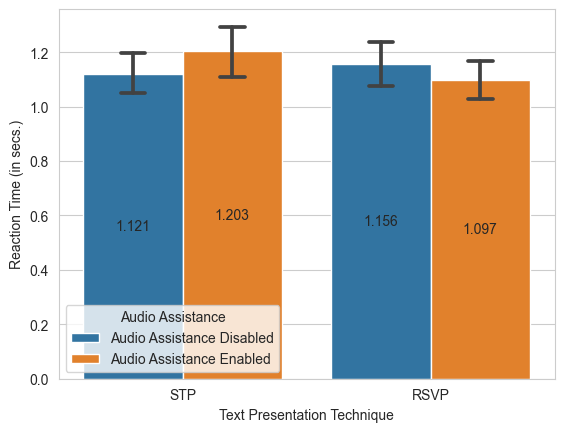

In [177]:
# Restructuring the data frame.
rt_refined = generate_refined(rt_df, "DP0", "RT")

# Combine columns TPT and Audio Assistance
rt_combined = pd.DataFrame()
rt_combined["TPTAA"] = rt_refined["TPT"].values + rt_refined["Audio Assistance"].values
rt_combined["Reaction Time (in secs.)"] = rt_refined["RT"].values
print(rt_df)
# Removing the outliers from the data frame
remove_outliers(rt_combined, "Reaction Time (in secs.)")

# Under sampling the data set
rt_combined = under_sampling(rt_combined, "Reaction Time (in secs.)")

# Creating sperate arrays for analysis
rt_stp, rt_stpa, rt_rsvp, rt_rsvpa = create_seperate_arrays(rt_combined, "Reaction Time (in secs.)")

# Do hypothesis Testing.
test_hypothesis(arr_stp=rt_stp, arr_stpa=rt_stpa, arr_rsvp=rt_rsvp, arr_rsvpa=rt_rsvpa, metric_name="RT")

# plot graph
plot_driving_metric(rt_combined, "Reaction Time (in secs.)", False)

Data is not Normal. Running Wilcoxon Signed Rank Test.
Test: ALPO_rsvp < ALPO_stp [INSIGNIFICANT] [p value: 0.5556867197272879]
Test: ALPO_rsvpa < ALPO_stpa [INSIGNIFICANT] [p value: 0.8450201869560001]
Test: ALPO_rsvpa < ALPO_rsvp [INSIGNIFICANT] [p value: 0.973642724652477]
Test: ALPO_stpa < ALPO_stp [INSIGNIFICANT] [p value: 0.7544440335283377]
Test: ALPO_rsvp > ALPO_stp [INSIGNIFICANT] [p value: 0.4443132802727121]
Test: ALPO_rsvpa > ALPO_stpa [INSIGNIFICANT] [p value: 0.15497981304399983]
Test: ALPO_rsvpa > ALPO_rsvp [***SIGNIFICANT***] [p value: 0.026357275347523003]
Test: ALPO_stpa > ALPO_stp [INSIGNIFICANT] [p value: 0.24555596647166233]


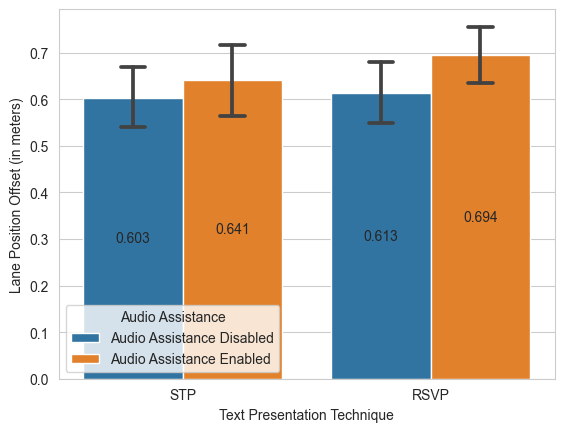

In [178]:
# Analyzing the Average Lane Position Offset.
sd_lane_pos = []
lpd_df_copy = lpd_df.copy()
for i in range(0, lpd_df_copy.shape[0]):
    dp_array = [dp for dp in lpd_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    sd_lane_pos.append(sum(dp_array) / len(dp_array))
lpd_df_copy["AVG"] = sd_lane_pos

# Restructuring the data frame.
lpd_refined = generate_refined(lpd_df_copy, "AVG", "LPO")

# Combine columns TPT and Audio Assistance
lpd_combined = pd.DataFrame()
lpd_combined["TPTAA"] = lpd_refined["TPT"].values + lpd_refined["Audio Assistance"].values
lpd_combined["Lane Position Offset (in meters)"] = lpd_refined["LPO"].values

# Removing the outliers from the data frame
remove_outliers(lpd_combined, "Lane Position Offset (in meters)")

# Under sampling the data set
lpd_combined = under_sampling(lpd_combined, "Lane Position Offset (in meters)")

# Creating separate arrays for analysis
alpo_stp, alpo_stpa, alpo_rsvp, alpo_rsvpa = create_seperate_arrays(lpd_combined, "Lane Position Offset (in meters)")

# Do hypothesis Testing.
test_hypothesis(arr_stp=alpo_stp, arr_stpa=alpo_stpa, arr_rsvp=alpo_rsvp, arr_rsvpa=alpo_rsvpa, metric_name="ALPO")

# Getting decoupled dataframe for the graph
plot_driving_metric(lpd_combined, "Lane Position Offset (in meters)", False)

Data is Normal. Running Paired T-test.
Test: SDLP_rsvp < SDLP_stp [INSIGNIFICANT] [p value: 0.6367014837137983]
Test: SDLP_rsvpa < SDLP_stpa [INSIGNIFICANT] [p value: 0.990878294970723]
Test: SDLP_rsvpa < SDLP_rsvp [INSIGNIFICANT] [p value: 0.9758835617818526]
Test: SDLP_stpa < SDLP_stp [INSIGNIFICANT] [p value: 0.6264265681333561]
Test: SDLP_rsvp > SDLP_stp [INSIGNIFICANT] [p value: 0.3632985162862018]
Test: SDLP_rsvpa > SDLP_stpa [***SIGNIFICANT***] [p value: 0.00912170502927703]
Test: SDLP_rsvpa > SDLP_rsvp [***SIGNIFICANT***] [p value: 0.02411643821814734]
Test: SDLP_stpa > SDLP_stp [INSIGNIFICANT] [p value: 0.37357343186664393]


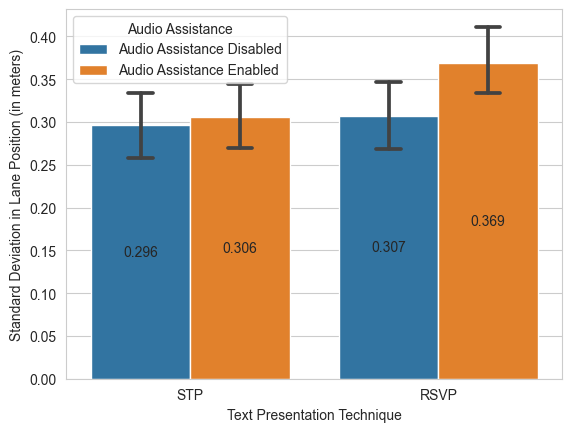

In [179]:
# Analyzing the Standard Deviation in Lane Position.
sd_lane_pos = []
lpd_df_copy = lpd_df.copy()
for i in range(0, lpd_df_copy.shape[0]):
    dp_array = [dp for dp in lpd_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    sd_lane_pos.append(np.std(dp_array))
lpd_df_copy["SD"] = sd_lane_pos

# Restructuring the data frame.
lpd_refined = generate_refined(lpd_df_copy, "SD", "SDLP")

# Combine columns TPT and Audio Assistance
lpd_combined = pd.DataFrame()
lpd_combined["TPTAA"] = lpd_refined["TPT"].values + lpd_refined["Audio Assistance"].values
lpd_combined["Standard Deviation in Lane Position (in meters)"] = lpd_refined["SDLP"].values

# Removing the outliers from the data frame
remove_outliers(lpd_combined, "Standard Deviation in Lane Position (in meters)")

# Under sampling the data set
lpd_combined = under_sampling(lpd_combined, "Standard Deviation in Lane Position (in meters)")

# Creating separate arrays for analysis
sdlp_stp, sdlp_stpa, sdlp_rsvp, sdlp_rsvpa = create_seperate_arrays(lpd_combined, "Standard Deviation in Lane Position (in meters)")

# Do hypothesis Testing.
test_hypothesis(arr_stp=sdlp_stp, arr_stpa=sdlp_stpa, arr_rsvp=sdlp_rsvp, arr_rsvpa=sdlp_rsvpa, metric_name="SDLP")

# Getting decoupled dataframe for the graph
plot_driving_metric(lpd_combined, "Standard Deviation in Lane Position (in meters)", False)

Data is not Normal. Running Wilcoxon Signed Rank Test.
Test: MSAV_rsvp < MSAV_stp [INSIGNIFICANT] [p value: 0.22340949408369676]
Test: MSAV_rsvpa < MSAV_stpa [***SIGNIFICANT***] [p value: 0.04570296632821677]
Test: MSAV_rsvpa < MSAV_rsvp [INSIGNIFICANT] [p value: 0.28047858837238293]
Test: MSAV_stpa < MSAV_stp [INSIGNIFICANT] [p value: 0.5074820677270993]
Test: MSAV_rsvp > MSAV_stp [INSIGNIFICANT] [p value: 0.7765905059163032]
Test: MSAV_rsvpa > MSAV_stpa [INSIGNIFICANT] [p value: 0.9542970336717832]
Test: MSAV_rsvpa > MSAV_rsvp [INSIGNIFICANT] [p value: 0.7195214116276171]
Test: MSAV_stpa > MSAV_stp [INSIGNIFICANT] [p value: 0.4925179322729007]


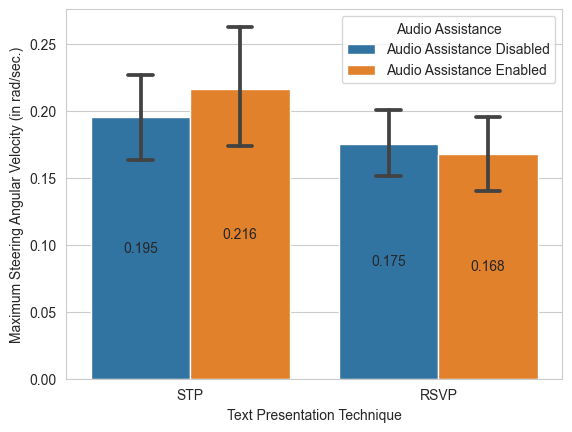

In [180]:
# Analyzing the Maximum Steering Angle Velocity [Not considering for data analysis]
MSVs = []
swv_df_copy = swv_df.copy()
for i in range(0, swv_df_copy.shape[0]):
    dp_array = [dp for dp in swv_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    MSVs.append(max(dp_array))
swv_df_copy["MAX"] = MSVs

# Restructuring the data frame.
msav_refined = generate_refined(swv_df_copy, "MAX", "MSAV")

# Combine columns TPT and Audio Assistance
msav_combined = pd.DataFrame()
msav_combined["TPTAA"] = msav_refined["TPT"].values + msav_refined["Audio Assistance"].values
msav_combined["Maximum Steering Angular Velocity (in rad/sec.)"] = msav_refined["MSAV"].values

# Removing the outliers from the data frame
remove_outliers(msav_combined, "Maximum Steering Angular Velocity (in rad/sec.)")

# Under sampling the data set
msav_combined = under_sampling(msav_combined, "Maximum Steering Angular Velocity (in rad/sec.)")

# Creating separate arrays for analysis
msav_stp, msav_stpa, msav_rsvp, msav_rsvpa = create_seperate_arrays(msav_combined,
                                                                    "Maximum Steering Angular Velocity (in rad/sec.)")
# Do hypothesis Testing.
test_hypothesis(arr_stp=msav_stp, arr_stpa=msav_stpa, arr_rsvp=msav_rsvp, arr_rsvpa=msav_rsvpa, metric_name="MSAV")

# Getting decoupled dataframe for the graph
plot_driving_metric(msav_combined, "Maximum Steering Angular Velocity (in rad/sec.)", False)

Data is not Normal. Running Wilcoxon Signed Rank Test.
Test: SDSWA_rsvp < SDSWA_stp [INSIGNIFICANT] [p value: 0.8485394770618899]
Test: SDSWA_rsvpa < SDSWA_stpa [INSIGNIFICANT] [p value: 0.9982616558636538]
Test: SDSWA_rsvpa < SDSWA_rsvp [INSIGNIFICANT] [p value: 0.934433469049752]
Test: SDSWA_stpa < SDSWA_stp [INSIGNIFICANT] [p value: 0.33210609010920517]
Test: SDSWA_rsvp > SDSWA_stp [INSIGNIFICANT] [p value: 0.15146052293811008]
Test: SDSWA_rsvpa > SDSWA_stpa [***SIGNIFICANT***] [p value: 0.0017383441363462207]
Test: SDSWA_rsvpa > SDSWA_rsvp [INSIGNIFICANT] [p value: 0.06556653095024804]
Test: SDSWA_stpa > SDSWA_stp [INSIGNIFICANT] [p value: 0.6678939098907948]


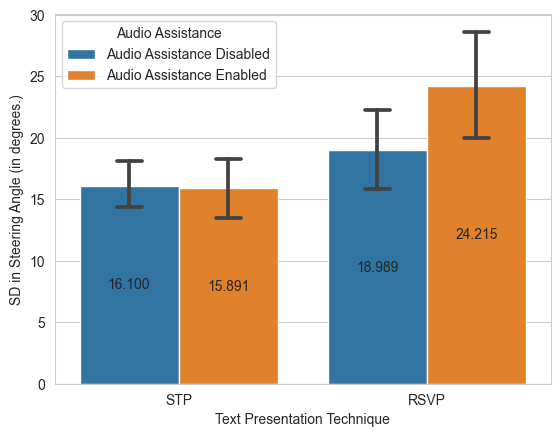

In [181]:
# Analyzing the Standard Deviation of Steering Wheel Angle
SWRRs = []
swa_df_copy = swa_df.copy()
for i in range(0, swa_df_copy.shape[0]):
    dp_array = [dp for dp in swa_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    SWRRs.append(np.std(dp_array))
swa_df_copy["SD"] = SWRRs

# Restructuring the data frame.
sdswa_refined = generate_refined(swa_df_copy, "SD", "SDSWA")

# Combine columns TPT and Audio Assistance
sdswa_combined = pd.DataFrame()
sdswa_combined["TPTAA"] = sdswa_refined["TPT"].values + sdswa_refined["Audio Assistance"].values
sdswa_combined["SD in Steering Angle (in degrees.)"] = sdswa_refined["SDSWA"].values

# Removing the outliers from the data frame
remove_outliers(sdswa_combined, "SD in Steering Angle (in degrees.)")

# Under sampling the data set
sdswa_combined = under_sampling(sdswa_combined, "SD in Steering Angle (in degrees.)")

# Create separate arrays for 2 x 2 cases
sdswa_stp, sdswa_stpa, sdswa_rsvp, sdswa_rsvpa = create_seperate_arrays(sdswa_combined,
                                                                        "SD in Steering Angle (in degrees.)")

# Do hypothesis Testing.
test_hypothesis(arr_stp=sdswa_stp, arr_stpa=sdswa_stpa, arr_rsvp=sdswa_rsvp, arr_rsvpa=sdswa_rsvpa, metric_name="SDSWA")

# plot graph
plot_driving_metric(sdswa_combined, "SD in Steering Angle (in degrees.)", False)

Data is not Normal. Running Wilcoxon Signed Rank Test.
Test: MSWR_rsvp < MSWR_stp [INSIGNIFICANT] [p value: 0.6615438366598599]
Test: MSWR_rsvpa < MSWR_stpa [INSIGNIFICANT] [p value: 0.8588806288504897]
Test: MSWR_rsvpa < MSWR_rsvp [INSIGNIFICANT] [p value: 0.47320866064280365]
Test: MSWR_stpa < MSWR_stp [INSIGNIFICANT] [p value: 0.09164577520917988]
Test: MSWR_rsvp > MSWR_stp [INSIGNIFICANT] [p value: 0.33845616334014006]
Test: MSWR_rsvpa > MSWR_stpa [INSIGNIFICANT] [p value: 0.14111937114951034]
Test: MSWR_rsvpa > MSWR_rsvp [INSIGNIFICANT] [p value: 0.5267913393571964]
Test: MSWR_stpa > MSWR_stp [INSIGNIFICANT] [p value: 0.9083542247908201]


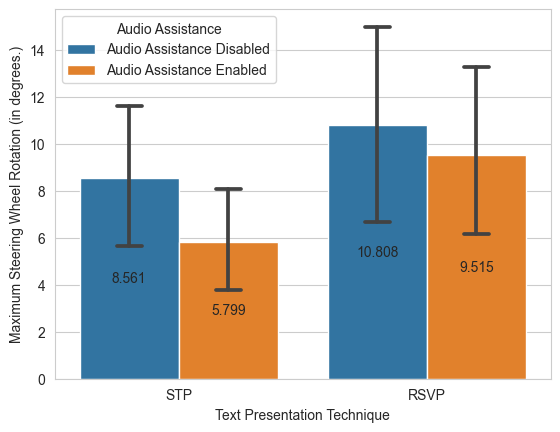

In [182]:
# Analyzing Maximum Steering Wheel Rotation
SWRRs = []
swa_df_copy = swa_df.copy()
for i in range(0, swa_df_copy.shape[0]):
    dp_array = [dp for dp in swa_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    SWRRs.append(max(dp_array))
swa_df_copy["MAX"] = SWRRs

# Restructuring the data frame.
mswr_refined = generate_refined(swa_df_copy, "MAX", "MAX")

# Combine columns TPT and Audio Assistance
mswr_combined = pd.DataFrame()
mswr_combined["TPTAA"] = mswr_refined["TPT"].values + mswr_refined["Audio Assistance"].values
mswr_combined["Maximum Steering Wheel Rotation (in degrees.)"] = mswr_refined["MAX"].values

# Removing the outliers from the data frame
remove_outliers(mswr_combined, "Maximum Steering Wheel Rotation (in degrees.)")

# Under sampling the data set
mswr_combined = under_sampling(mswr_combined, "Maximum Steering Wheel Rotation (in degrees.)")

# Create separate arrays for 2 x 2 cases
mswr_stp, mswr_stpa, mswr_rsvp, mswr_rsvpa = create_seperate_arrays(mswr_combined,
                                                                            "Maximum Steering Wheel Rotation (in degrees.)")

# Do hypothesis Testing.
test_hypothesis(arr_stp=mswr_stp, arr_stpa=mswr_stpa, arr_rsvp=mswr_rsvp, arr_rsvpa=mswr_rsvpa, metric_name="MSWR")

# plot graph
plot_driving_metric(mswr_combined, "Maximum Steering Wheel Rotation (in degrees.)", False)

Shapiro Test for BIR_stp; p-value:  0.26218539476394653
Shapiro Test for BIR_rsvp; p-value:  0.030646266415715218
Shapiro Test for BIR_stpa; p-value:  0.28368523716926575
Shapiro Test for BIR_rsvpa; p-value:  0.04766403138637543
Data is not Normal. Running Wilcoxon Signed Rank Test.
Test: BIR_rsvp < BIR_stp [INSIGNIFICANT] [p value: 0.4825467308050094]
Test: BIR_rsvpa < BIR_stpa [INSIGNIFICANT] [p value: 0.9572159123003608]
Test: BIR_rsvpa < BIR_rsvp [INSIGNIFICANT] [p value: 0.5907303452375682]
Test: BIR_stpa < BIR_stp [INSIGNIFICANT] [p value: 0.08812454644320583]
Test: BIR_rsvp > BIR_stp [INSIGNIFICANT] [p value: 0.5174532691949906]
Test: BIR_rsvpa > BIR_stpa [***SIGNIFICANT***] [p value: 0.04278408769963919]
Test: BIR_rsvpa > BIR_rsvp [INSIGNIFICANT] [p value: 0.4092696547624319]
Test: BIR_stpa > BIR_stp [INSIGNIFICANT] [p value: 0.9118754535567941]


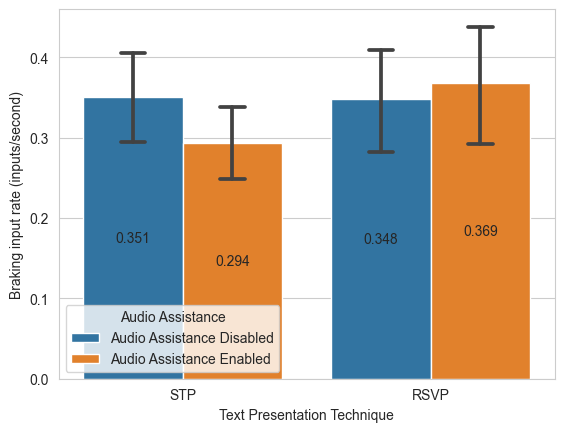

In [190]:
# Analysing the Breaking Input Rate
# Creating a duplicate df to retain original data, and calculating rate
bi_df_copy = bi_df.copy()
BIRs = []
for i in range(0, bi_df_copy.shape[0]):
    dp_array = [dp for dp in bi_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    count = 0
    for value in dp_array:
        if value != 0:
            count += 1
    rate = float(count) / len(dp_array)
    BIRs.append(rate)
bi_df_copy["RATE"] = BIRs

# Restructuring the data frame.
bir_refined = generate_refined(bi_df_copy, "RATE", "RATE")

# Combine columns TPT and Audio Assistance
bir_combined = pd.DataFrame()
bir_combined["TPTAA"] = bir_refined["TPT"].values + bir_refined["Audio Assistance"].values
bir_combined["Braking input rate (inputs/second)"] = bir_refined["RATE"].values

# Removing the outliers from the data frame
remove_outliers(bir_combined, "Braking input rate (inputs/second)")

# Under sampling the data set
bir_combined = under_sampling(bir_combined, "Braking input rate (inputs/second)")

# Create separate arrays for 2 x 2 cases
bir_stp, bir_stpa, bir_rsvp, bir_rsvpa = create_seperate_arrays(bir_combined, "Braking input rate (inputs/second)")

# Test if the distribution is normal.
print("Shapiro Test for BIR_stp; p-value: ", stats.shapiro(bir_stp)[1])
print("Shapiro Test for BIR_rsvp; p-value: ", stats.shapiro(bir_rsvp)[1])
print("Shapiro Test for BIR_stpa; p-value: ", stats.shapiro(bir_stpa)[1])
print("Shapiro Test for BIR_rsvpa; p-value: ", stats.shapiro(bir_rsvpa)[1])

# Do hypothesis Testing.
test_hypothesis(arr_stp=bir_stp, arr_stpa=bir_stpa, arr_rsvp=bir_rsvp, arr_rsvpa=bir_rsvpa, metric_name="BIR")

# plot graph
plot_driving_metric(bir_combined, "Braking input rate (inputs/second)", False)

Data is not Normal. Running Wilcoxon Signed Rank Test.
Test: MBI_rsvp < MBI_stp [INSIGNIFICANT] [p value: 0.15994906816219512]
Test: MBI_rsvpa < MBI_stpa [INSIGNIFICANT] [p value: 0.8018876818315497]
Test: MBI_rsvpa < MBI_rsvp [INSIGNIFICANT] [p value: 0.4096279796497599]
Test: MBI_stpa < MBI_stp [***SIGNIFICANT***] [p value: 0.01906943293864131]
Test: MBI_rsvp > MBI_stp [INSIGNIFICANT] [p value: 0.8400509318378049]
Test: MBI_rsvpa > MBI_stpa [INSIGNIFICANT] [p value: 0.19811231816845032]
Test: MBI_rsvpa > MBI_rsvp [INSIGNIFICANT] [p value: 0.5903720203502401]
Test: MBI_stpa > MBI_stp [INSIGNIFICANT] [p value: 0.9809305670613587]


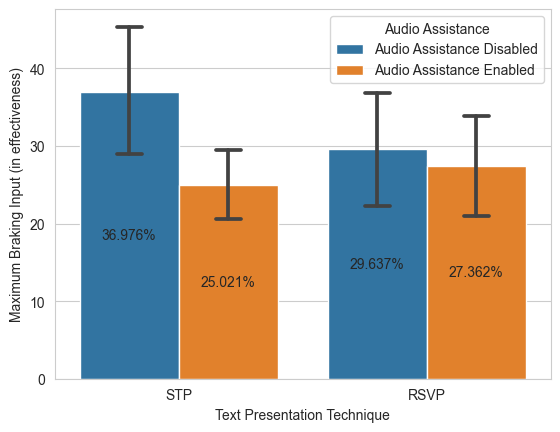

In [191]:
# Analysing the Maximum breaking input
# Creating a duplicate df to retain original data, and calculating rate
bi_df_copy = bi_df.copy()
MBSs = []
for i in range(0, bi_df_copy.shape[0]):
    dp_array = [dp for dp in bi_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    MBSs.append(max(dp_array) * 100)
bi_df_copy["MAX"] = MBSs

# Restructuring the data frame.
mbi_refined = generate_refined(bi_df_copy, "MAX", "MAX")

# Combine columns TPT and Audio Assistance
mbi_combined = pd.DataFrame()
mbi_combined["TPTAA"] = mbi_refined["TPT"].values + mbi_refined["Audio Assistance"].values
mbi_combined["Maximum Braking Input (in effectiveness)"] = mbi_refined["MAX"].values

# Removing the outliers from the data frame
remove_outliers(mbi_combined, "Maximum Braking Input (in effectiveness)")

# Under sampling the data set
mbi_combined = under_sampling(mbi_combined, "Maximum Braking Input (in effectiveness)")

# Create separate arrays for 2 x 2 cases
mbi_stp, mbi_stpa, mbi_rsvp, mbi_rsvpa = create_seperate_arrays(mbi_combined,
                                                                "Maximum Braking Input (in effectiveness)")

# Do hypothesis Testing.
test_hypothesis(arr_stp=mbi_stp, arr_stpa=mbi_stpa, arr_rsvp=mbi_rsvp, arr_rsvpa=mbi_rsvpa, metric_name="MBI")

# plot graph
plot_driving_metric(mbi_combined, "Maximum Braking Input (in effectiveness)", True)

Data is not Normal. Running Wilcoxon Signed Rank Test.
Test: MBS_rsvp < MBS_stp [INSIGNIFICANT] [p value: 0.15994906816219512]
Test: MBS_rsvpa < MBS_stpa [INSIGNIFICANT] [p value: 0.8018876818315497]
Test: MBS_rsvpa < MBS_rsvp [INSIGNIFICANT] [p value: 0.4096279796497599]
Test: MBS_stpa < MBS_stp [***SIGNIFICANT***] [p value: 0.01906943293864131]
Test: MBS_rsvp > MBS_stp [INSIGNIFICANT] [p value: 0.8400509318378049]
Test: MBS_rsvpa > MBS_stpa [INSIGNIFICANT] [p value: 0.19811231816845032]
Test: MBS_rsvpa > MBS_rsvp [INSIGNIFICANT] [p value: 0.5903720203502401]
Test: MBS_stpa > MBS_stp [INSIGNIFICANT] [p value: 0.9809305670613587]


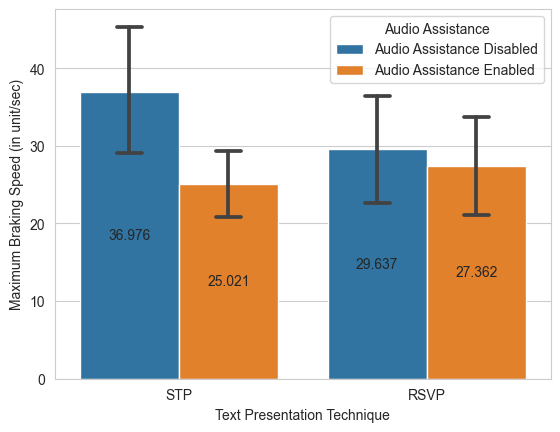

In [192]:
# Analysing the Maximum Braking Speed
# Creating a duplicate df to retain original data, and calculating rate
bi_df_copy = bi_df.copy()
MBSs = []
for i in range(0, bi_df_copy.shape[0]):
    dp_array = [dp for dp in bi_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    max_speed = None
    for i in range(0, len(dp_array) - 1):
        if max_speed is None:
            max_speed = dp_array[i] - dp_array[i + 1]
        else:
            max_speed = max_speed if max_speed >= (dp_array[i] - dp_array[i + 1]) else (dp_array[i] - dp_array[i + 1])
    MBSs.append(max(dp_array) * 100)
bi_df_copy["MAXSPEED"] = MBSs

# Restructuring the data frame.
mbs_refined = generate_refined(bi_df_copy, "MAXSPEED", "MAXSPEED")

# Combine columns TPT and Audio Assistance
mbs_combined = pd.DataFrame()
mbs_combined["TPTAA"] = mbs_refined["TPT"].values + mbs_refined["Audio Assistance"].values
mbs_combined["Maximum Braking Speed (in unit/sec)"] = mbs_refined["MAXSPEED"].values

# Removing the outliers from the data frame
remove_outliers(mbs_combined, "Maximum Braking Speed (in unit/sec)")

# Under sampling the data set
mbs_combined = under_sampling(mbs_combined, "Maximum Braking Speed (in unit/sec)")

# Create separate arrays for 2 x 2 cases
mbs_stp, mbs_stpa, mbs_rsvp, mbs_rsvpa = create_seperate_arrays(mbs_combined, "Maximum Braking Speed (in unit/sec)")

# Do hypothesis Testing.
test_hypothesis(arr_stp=mbs_stp, arr_stpa=mbs_stpa, arr_rsvp=mbs_rsvp, arr_rsvpa=mbs_rsvpa, metric_name="MBS")

# plot graph
plot_driving_metric(mbs_combined, "Maximum Braking Speed (in unit/sec)", False)

Data is not Normal. Running Wilcoxon Signed Rank Test.
Test: SWRR_rsvp < SWRR_stp [***SIGNIFICANT***] [p value: 0.03302788408924859]
Test: SWRR_rsvpa < SWRR_stpa [INSIGNIFICANT] [p value: 0.1104157891315059]
Test: SWRR_rsvpa < SWRR_rsvp [INSIGNIFICANT] [p value: 0.8686388765796402]
Test: SWRR_stpa < SWRR_stp [INSIGNIFICANT] [p value: 0.5287288880226045]
Test: SWRR_rsvp > SWRR_stp [INSIGNIFICANT] [p value: 0.9669721159107514]
Test: SWRR_rsvpa > SWRR_stpa [INSIGNIFICANT] [p value: 0.8895842108684942]
Test: SWRR_rsvpa > SWRR_rsvp [INSIGNIFICANT] [p value: 0.13136112342035983]
Test: SWRR_stpa > SWRR_stp [INSIGNIFICANT] [p value: 0.47127111197739546]


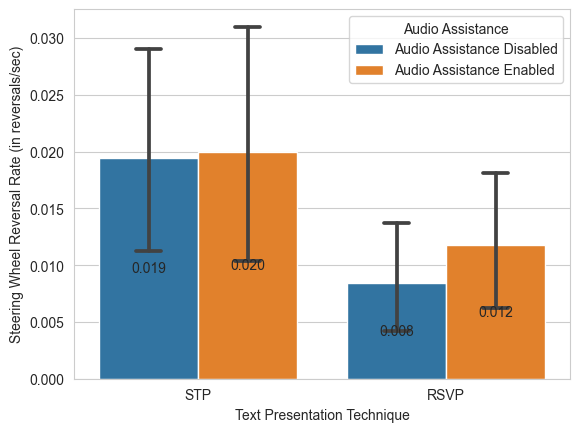

In [193]:
# Analyzing the Steering Wheel Reversal Rate
SWRRs = []
swa_df_copy = swa_df.copy()
GapSize = 10.0
for i in range(0, swa_df_copy.shape[0]):
    dp_array = [dp for dp in swa_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    count = 0
    total_time = 0
    for j in range(0, len(dp_array) - 1):
        if abs(dp_array[j] - dp_array[j + 1]) > GapSize:
            count += 1
        total_time += 0.2

    SWRRs.append(count / total_time)
swa_df_copy["RATE"] = SWRRs

# Restructuring the data frame.
swrr_refined = generate_refined(swa_df_copy, "RATE", "RATE")

# Combine columns TPT and Audio Assistance
swrr_combined = pd.DataFrame()
swrr_combined["TPTAA"] = swrr_refined["TPT"].values + swrr_refined["Audio Assistance"].values
swrr_combined["Steering Wheel Reversal Rate (in reversals/sec)"] = swrr_refined["RATE"].values

# Removing the outliers from the data frame
remove_outliers(swrr_combined, "Steering Wheel Reversal Rate (in reversals/sec)")

# Under sampling the data set
swrr_combined = under_sampling(swrr_combined, "Steering Wheel Reversal Rate (in reversals/sec)")

# Create separate arrays for 2 x 2 cases
swrr_stp, swrr_stpa, swrr_rsvp, swrr_rsvpa = create_seperate_arrays(swrr_combined,
                                                                    "Steering Wheel Reversal Rate (in reversals/sec)")

# Do hypothesis Testing.
test_hypothesis(arr_stp=swrr_stp, arr_stpa=swrr_stpa, arr_rsvp=swrr_rsvp, arr_rsvpa=swrr_rsvpa, metric_name="SWRR")

# plot graph
plot_driving_metric(swrr_combined, "Steering Wheel Reversal Rate (in reversals/sec)", False)

,Question,STP,RSVP
0,Q1,54.1875,48.208333333333336
1,Q2,39.541666666666664,32.75
2,Q3,49.5625,50.0625
3,Q4,60.979166666666664,60.125
4,Q5,53.479166666666664,47.166666666666664
5,Q6,41.6875,38.791666666666664


KeyError: 'STP'

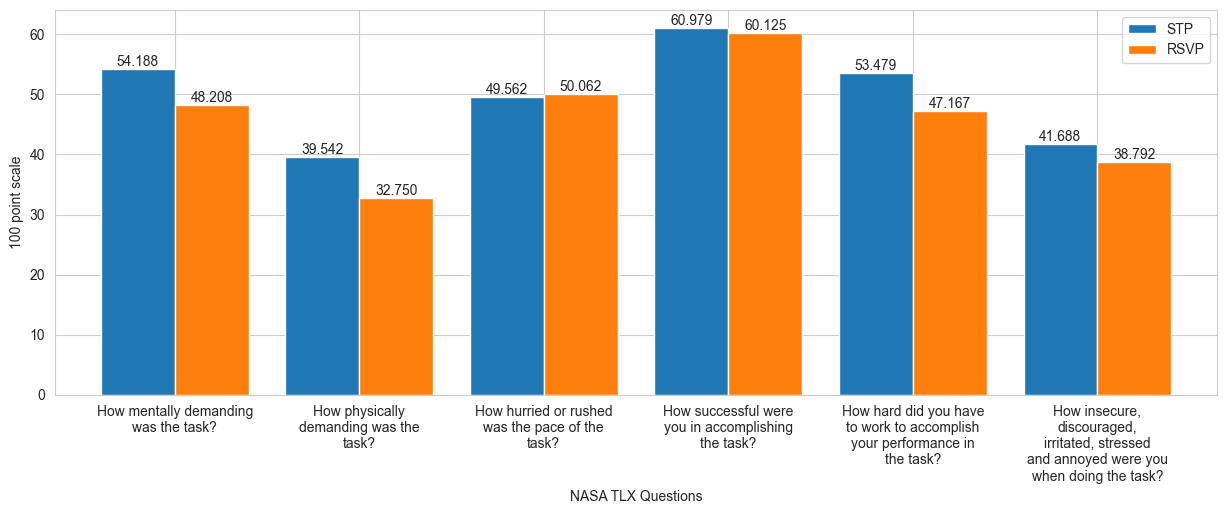

In [195]:
# Analyzing NASA-TLX form.
# Q1: Enter Participant ID
# Q2: Type of Display
# Q3: Text Presentation Technique
# Q4_1 How mentally demanding was the task?
# Q4_2: How physically demanding was the task?
# Q4_3: How hurried or rushed was the pace of the task?
# Q4_4: How successful were you in accomplishing the task?
# Q4_5: How hard did you have to work to accomplish your performance in the task?
# Q4_6: How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?
axis_labels = [
    "How mentally demanding was the task?",
    "How physically demanding was the task?",
    "How hurried or rushed was the pace of the task?",
    "How successful were you in accomplishing the task?",
    "How hard did you have to work to accomplish your performance in the task?",
    "How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?"
]
labels = []
for label in axis_labels:
    labels.append(textwrap.fill(label, width=22,
                                break_long_words=False))

nasa_tlx_stp = nasa_tlx[nasa_tlx["Q3"] == "Scrolling Text Presentation (STP)"]
nasa_tlx_rsvp = nasa_tlx[nasa_tlx["Q3"] == "Rapid Serial Visual Presentation (RSVP)"]
nasa_tlx_aae = nasa_tlx[nasa_tlx["Q2"] == "Yes (HUDAA)"]
nasa_tlx_aad = nasa_tlx[nasa_tlx["Q2"] == "No (HUD)"]

TPT_diff = np.array([
    ["Q1", np.mean(nasa_tlx_stp["Q4_1"]), np.mean(nasa_tlx_rsvp["Q4_1"])],
    ["Q2", np.mean(nasa_tlx_stp["Q5_1"]), np.mean(nasa_tlx_rsvp["Q5_1"])],
    ["Q3", np.mean(nasa_tlx_stp["Q6_1"]), np.mean(nasa_tlx_rsvp["Q6_1"])],
    ["Q4", np.mean(nasa_tlx_stp["Q7_1"]), np.mean(nasa_tlx_rsvp["Q7_1"])],
    ["Q5", np.mean(nasa_tlx_stp["Q8_1"]), np.mean(nasa_tlx_rsvp["Q8_1"])],
    ["Q6", np.mean(nasa_tlx_stp["Q9_1"]), np.mean(nasa_tlx_rsvp["Q9_1"])],

])

AA_diff = np.array([
    ["Q1", np.mean(nasa_tlx_aad["Q4_1"]), np.mean(nasa_tlx_aae["Q4_1"])],
    ["Q2", np.mean(nasa_tlx_aad["Q5_1"]), np.mean(nasa_tlx_aae["Q5_1"])],
    ["Q3", np.mean(nasa_tlx_aad["Q6_1"]), np.mean(nasa_tlx_aae["Q6_1"])],
    ["Q4", np.mean(nasa_tlx_aad["Q7_1"]), np.mean(nasa_tlx_aae["Q7_1"])],
    ["Q5", np.mean(nasa_tlx_aad["Q8_1"]), np.mean(nasa_tlx_aae["Q8_1"])],
    ["Q6", np.mean(nasa_tlx_aad["Q9_1"]), np.mean(nasa_tlx_aae["Q9_1"])],
])

nasa_tlx_tpt_df = pd.DataFrame(TPT_diff, columns=["Question", "STP", "RSVP"])
nasa_tlx_aa_df = pd.DataFrame(AA_diff, columns=["Question", "AAD", "AAE"])

display(nasa_tlx_tpt_df)

# Converting the column types
nasa_tlx_tpt_df["Question"] = nasa_tlx_tpt_df["Question"].astype(str)
nasa_tlx_tpt_df["STP"] = nasa_tlx_tpt_df["STP"].astype(float)
nasa_tlx_tpt_df["RSVP"] = nasa_tlx_tpt_df["RSVP"].astype(float)

nasa_tlx_aa_df["Question"] = nasa_tlx_aa_df["Question"].astype(str)
nasa_tlx_aa_df["AAD"] = nasa_tlx_aa_df["AAD"].astype(float)
nasa_tlx_aa_df["AAE"] = nasa_tlx_aa_df["AAE"].astype(float)

# RSVP vs STP
bplot = nasa_tlx_tpt_df.plot(x="Question", kind="bar", width=0.8, rot=0, figsize=(15, 5))

bplot.set_xticklabels(labels, rotation=0)

plt.xlabel("NASA TLX Questions")
plt.ylabel("100 point scale")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')

# Audio assistance disabled vs audio assistance enabled
bplot2 = nasa_tlx_aa_df.plot(x="Question", kind="bar", width=0.8, rot=0, figsize=(15, 5))
bplot2.set_xticklabels(labels, rotation=0)
bplot2.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"])

plt.xlabel("NASA TLX Questions")
plt.ylabel("100 point scale")
for p in bplot2.containers:
    bplot2.bar_label(p, fmt='%.3f', label_type='edge')

Testing and plotting for Q: How mentally demanding was the task?
Test: R_rsvp < R_stp [p value: 0.39687561179577757]
Test: R_rsvpa < R_stpa [p value: 0.0835365421655011]
Test: R_rsvpa < R_rsvp [p value: 0.09564758048051214]
Test: R_stpa < R_stp [p value: 0.16882991790771484]
Test: R_rsvp > R_stp [p value: 0.6031243882042224]
Test: R_rsvpa > R_stpa [p value: 0.9164634578344989]
Test: R_rsvpa > R_rsvp [p value: 0.9043524195194879]
Test: R_stpa > R_stp [p value: 0.8397712707519531]

Testing and plotting for Q: How physically demanding was the task?
Test: R_rsvp < R_stp [p value: 0.35396718978881836]
Test: R_rsvpa < R_stpa [p value: 0.015635354965123964]
Test: R_rsvpa < R_rsvp [p value: 0.0228775328138283]
Test: R_stpa < R_stp [p value: 0.29270124435424805]
Test: R_rsvp > R_stp [p value: 0.6586432456970215]
Test: R_rsvpa > R_stpa [p value: 0.9843646450348761]
Test: R_rsvpa > R_rsvp [p value: 0.9771224671861717]
Test: R_stpa > R_stp [p value: 0.7189626693725586]

Testing and plotting for Q:

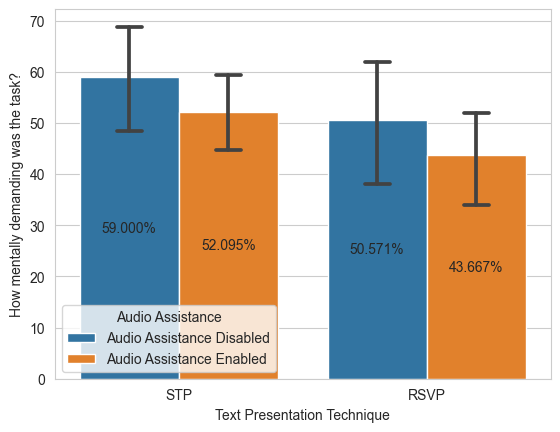

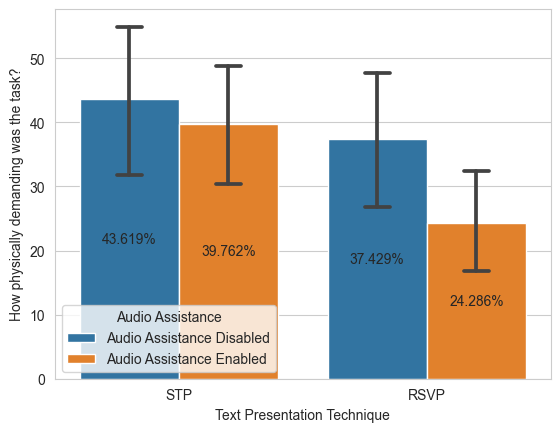

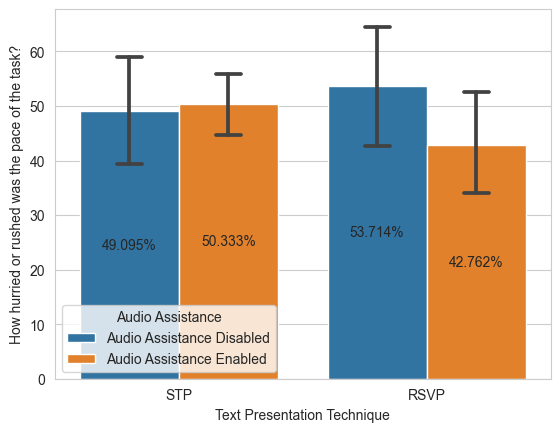

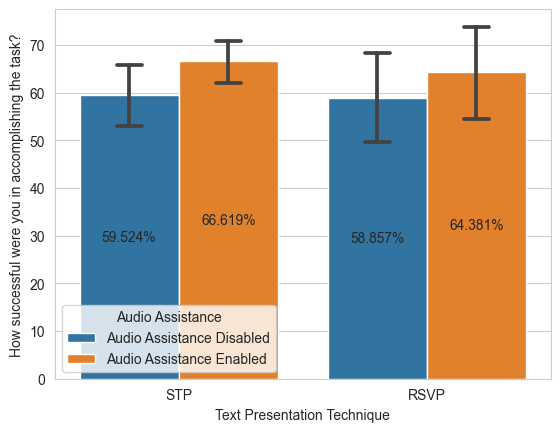

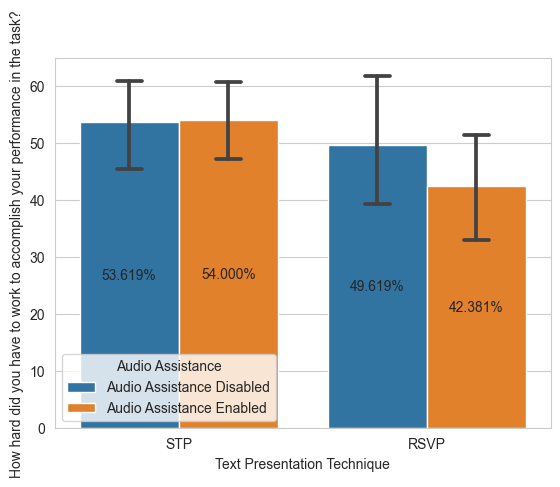

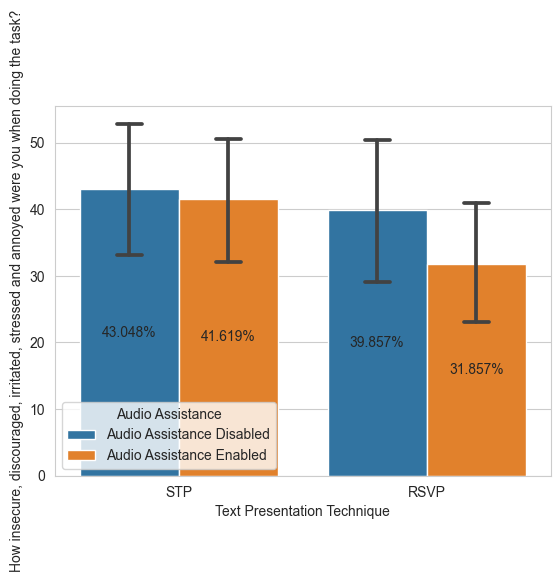

<Figure size 640x480 with 0 Axes>

In [188]:
# Analyzing NASA-TLX form.
# Q1: Enter Participant ID
# Q2: Type of Display
# Q3: Text Presentation Technique
# Q4_1: How mentally demanding was the task?
# Q5_1: How physically demanding was the task?
# Q6_1: How hurried or rushed was the pace of the task?
# Q7_1: How successful were you in accomplishing the task?
# Q8_1: How hard did you have to work to accomplish your performance in the task?
# Q9_1: How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?

axis_labels = [
    "How mentally demanding was the task?",
    "How physically demanding was the task?",
    "How hurried or rushed was the pace of the task?",
    "How successful were you in accomplishing the task?",
    "How hard did you have to work to accomplish your performance in the task?",
    "How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?"
]
# Rename the dataframe to make it standardized
nasa_tlx_refined = nasa_tlx.rename(
    columns={'Q1': 'Participant_ID', 'Q3': 'TPT', 'Q2': 'AA', 'Q4_1': 'Q1', 'Q5_1': 'Q2', 'Q6_1': 'Q3', 'Q7_1': 'Q4',
             'Q8_1': 'Q5', 'Q9_1': 'Q6'}, inplace=False)

# Combining TPT and AA columns
nasa_tlx_combined = pd.DataFrame()
tpt_list = [("STP" if "STP" in value else "RSVP") for value in nasa_tlx_refined["TPT"].values.tolist()]
aa_list = [("NAA" if "No" in value else "AA") for value in nasa_tlx_refined["AA"].values.tolist()]
nasa_tlx_combined["TPTAA"] = [tpt_list[i] + aa_list[i] for i in range(0, len(aa_list))]
for i in range(1, 7):
    nasa_tlx_combined["Q" + str(i)] = nasa_tlx_refined["Q" + str(i)].values

# Removing the outliers
for i in range(1, 7):
    remove_outliers(nasa_tlx_combined, "Q" + str(i))

# Under sampling the data set and creating separate data frames
Ratings = []
for i in range(1, 7):
    df = under_sampling(nasa_tlx_combined, "Q" + str(i))
    Ratings.append(df)
# Rating[0] = "Q1", Rating[1] = "Q2", Rating[2] = "Q3", Rating[3] = "Q4", Rating[4] = "Q5", Rating[5] = "Q6"

# Analyze the questions individually
print("Testing and plotting for Q:", axis_labels[0])
analyze_nasa_tlx(df=Ratings[0], data_col="Q1", plot_y_label=axis_labels[0])

print("\nTesting and plotting for Q:", axis_labels[1])
analyze_nasa_tlx(df=Ratings[1], data_col="Q2", plot_y_label=axis_labels[1])

print("\nTesting and plotting for Q:", axis_labels[2])
analyze_nasa_tlx(df=Ratings[2], data_col="Q3", plot_y_label=axis_labels[2])

print("\nTesting and plotting for Q:", axis_labels[3])
analyze_nasa_tlx(df=Ratings[3], data_col="Q4", plot_y_label=axis_labels[3])

print("\nTesting and plotting for Q:", axis_labels[4])
analyze_nasa_tlx(df=Ratings[4], data_col="Q5", plot_y_label=axis_labels[4])

print("\nTesting and plotting for Q:", axis_labels[5])
analyze_nasa_tlx(df=Ratings[5], data_col="Q6", plot_y_label=axis_labels[5])

      TPTAA  Accuracy (in percentage)
0    STPNAA                 90.000000
1     STPAA                 30.000000
2   RSVPNAA                 70.833333
3    RSVPAA                 30.000000
4    STPNAA                100.000000
..      ...                       ...
91   RSVPAA                 70.000000
92   STPNAA                 58.333333
93    STPAA                 67.500000
94  RSVPNAA                 60.000000
95   RSVPAA                 65.000000

[96 rows x 2 columns]
Shapiro Test for comp_stp; p-value: 0.3648160398006439
Shapiro Test for comp_rsvp; p-value: 0.11851862072944641
Shapiro Test for comp_stpa; p-value: 0.12051497399806976
Shapiro Test for comp_rsvpa; p-value: 0.15402355790138245 

H_0: COMP_rsvp = COMP_stp ; H_a: COMP_rsvp < COMP_stp
Ttest_relResult(statistic=-0.37913192451505373, pvalue=0.35403377024487565)
H_0: COMP_rsvpa = COMP_stpa ; H_a: COMP_rsvpa < COMP_stpa
Ttest_relResult(statistic=-0.055642875453451195, pvalue=0.4780534260266627)
H_0: COMP_rsvpa = COMP_rsvp 

,Participant_ID,TPT,Audio Assistance,Accuracy
0,P06,STP,NAA,90.000000
1,P06,STP,AA,30.000000
2,P06,RSVP,NAA,70.833333
3,P06,RSVP,AA,30.000000
4,P07,STP,NAA,100.000000
...,...,...,...,...
91,P29,RSVP,AA,70.000000
92,P30,STP,NAA,58.333333
93,P30,STP,AA,67.500000
94,P30,RSVP,NAA,60.000000


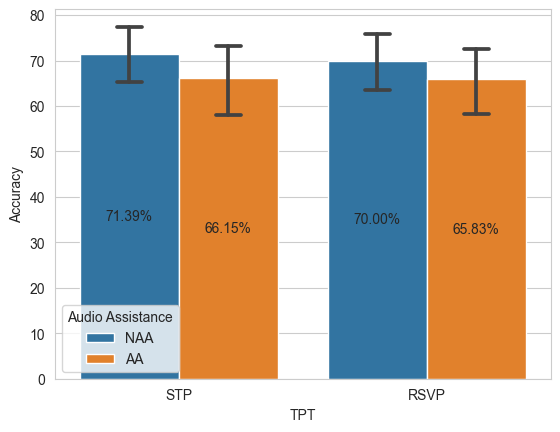

In [189]:
correct_answers = [1, 2, 3, 4, 2, 1, 3, 2, 4, 2, 4, 2, 3, 3, 4, 1, 2, 1, 3, 2, 1, 3, 4, 2, 1, 1, 2, 3, 1, 2, 1, 1, 1, 2,
                   1, 4, 4, 4, 2]
acc_col = []
for i in range(0, comp_test_df.shape[0]):
    try:
        row = [dp for dp in comp_test_df.iloc[i].values.tolist()[4:]]
        correct = 0
        incorrect = 0
        for j in range(0, len(correct_answers)):
            if not math.isnan(row[j]):
                if row[j] == correct_answers[j]:
                    correct += 1
                else:
                    incorrect += 1
        acc_col.append(float(correct) / (correct + incorrect))
    except Exception as e:
        print(i, e)

comp_test_acc_df = pd.DataFrame().assign(Participant_ID=comp_test_df['Q1'], AA=comp_test_df['Qa'],
                                         TPT=comp_test_df['Qb'], TF=comp_test_df['Qc'])
comp_test_acc_df['Accuracy'] = acc_col
# AA = 1 If Enabled, 2 If Disabled
# TPT = 1 If STP, 2 If RSVP
# TF ranges between 1-8

# Creating a dataframe to plot the data
comp_test_refined_df = pd.DataFrame(columns=['Participant_ID', 'TPT', 'Audio Assistance', 'Accuracy'])
comp_test_refined_df["Accuracy"] = comp_test_refined_df["Accuracy"].astype(float)

for participant in comp_test_acc_df["Participant_ID"].unique():
    # Get the dataframe for the participant
    participant_df = comp_test_acc_df[comp_test_acc_df["Participant_ID"] == participant]

    # Get the dataframe for each of the four cases
    df_row_stp = [participant, "STP", "NAA"]
    df_row_rsvp = [participant, "RSVP", "NAA"]
    df_row_stpa = [participant, "STP", "AA"]
    df_row_rsvpa = [participant, "RSVP", "AA"]

    # Adding the stp NAA test value
    df_row_stp.append(
        participant_df[(participant_df["AA"] == 2) & (participant_df["TPT"] == 1)]["Accuracy"].values.mean() * 100)
    # Adding the stp AA test value
    df_row_stpa.append(
        participant_df[(participant_df["AA"] == 1) & (participant_df["TPT"] == 1)]["Accuracy"].values.mean() * 100)
    # Adding the rsvp NAA test value
    df_row_rsvp.append(
        participant_df[(participant_df["AA"] == 2) & (participant_df["TPT"] == 2)]["Accuracy"].values.mean() * 100)
    # Adding the rsvpa AA test value
    df_row_rsvpa.append(
        participant_df[(participant_df["AA"] == 1) & (participant_df["TPT"] == 2)]["Accuracy"].values.mean() * 100)

    # Adding the rows in the dataframe
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_stp
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_stpa
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_rsvp
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_rsvpa

# Combine columns TPT and Audio Assistance
comp_combined = pd.DataFrame()
comp_combined["TPTAA"] = comp_test_refined_df["TPT"].values + comp_test_refined_df["Audio Assistance"].values
comp_combined["Accuracy (in percentage)"] = comp_test_refined_df["Accuracy"].values
print(comp_combined)

# Removing the outliers from the data frame
remove_outliers(comp_combined, "Accuracy (in percentage)")

# Under sampling the data set
comp_combined = under_sampling(comp_combined, "Accuracy (in percentage)")

# Create separate arrays for 2 x 2 cases
comp_stp, comp_stpa, comp_rsvp, comp_rsvpa = create_seperate_arrays(comp_combined,
                                                                    "Accuracy (in percentage)")

# Perform P-tests foer texting the hypothesis
print("Shapiro Test for comp_stp; p-value:", stats.shapiro(comp_stp)[1])
print("Shapiro Test for comp_rsvp; p-value:", stats.shapiro(comp_rsvp)[1])
print("Shapiro Test for comp_stpa; p-value:", stats.shapiro(comp_stpa)[1])
print("Shapiro Test for comp_rsvpa; p-value:", stats.shapiro(comp_rsvpa)[1], "\n")

# Perform Mann Whitney U test
print("H_0: COMP_rsvp = COMP_stp ; H_a: COMP_rsvp < COMP_stp")
print(stats.ttest_rel(a=comp_rsvp, b=comp_stp, alternative="less"))
print("H_0: COMP_rsvpa = COMP_stpa ; H_a: COMP_rsvpa < COMP_stpa")
print(stats.ttest_rel(a=comp_rsvpa, b=comp_stpa, alternative="less"))
# Test if H_a: COMP_aae < COMP_aad
print("H_0: COMP_rsvpa = COMP_rsvp ; H_a: COMP_rsvpa < COMP_rsvp")
print(stats.ttest_rel(a=comp_rsvpa, b=comp_rsvp, alternative="less"))
print("H_0: COMP_stpa = COMP_stp ; H_a: COMP_stpa < COMP_stp")
print(stats.ttest_rel(a=comp_stpa, b=comp_stp, alternative="less"))

# Test if H_a: COMP_rsvp > COMP_stp
print("H_0: COMP_rsvp = COMP_stp ; H_a: COMP_rsvp > COMP_stp")
print(stats.ttest_rel(a=comp_rsvp, b=comp_stp, alternative="greater"))
print("H_0: COMP_rsvpa = COMP_stpa ; H_a: COMP_rsvpa > COMP_stpa")
print(stats.ttest_rel(a=comp_rsvpa, b=comp_stpa, alternative="greater"))
# Test if H_a: COMP_aae > COMP_aad
print("H_0: COMP_rsvpa = COMP_rsvp ; H_a: COMP_rsvpa > COMP_rsvp")
print(stats.ttest_rel(a=comp_rsvpa, b=comp_rsvp, alternative="greater"))
print("H_0: COMP_stpa = COMP_stp ; H_a: COMP_stpa > COMP_stp")
print(stats.ttest_rel(a=comp_stpa, b=comp_stp, alternative="greater"))

plot = sns.barplot(data=comp_test_refined_df, x="TPT", y="Accuracy", hue="Audio Assistance", capsize=0.1)
for p in plot.containers:
    plot.bar_label(p, fmt='%.2f%%', label_type='center')
display(comp_test_refined_df)